Major definition

"Administrative", "Administrative Duration", "Informational", "Informational Duration", "Product Related" and "Product Related Duration" represent the number of different types of pages visited by the visitor in that session and total time spent in each of these page categories. The values of these features are derived from the URL information of the pages visited by the user and updated in real time when a user takes an action, e.g. moving from one page to another. The "Bounce Rate", "Exit Rate" and "Page Value" features represent the metrics measured by "Google Analytics" for each page in the e-commerce site. The value of "Bounce Rate" feature for a web page refers to the percentage of visitors who enter the site from that page and then leave ("bounce") without triggering any other requests to the analytics server during that session.

The value of "Exit Rate" feature for a specific web page is calculated as for all pageviews to the page, the percentage that were the last in the session. 

The "Page Value" feature represents the average value for a web page that a user visited before completing an e-commerce transaction.

The "Special Day" feature indicates the closeness of the site visiting time to a specific special day (e.g. Mother’s Day, Valentine's Day) in which the sessions are more likely to be finalized with transaction. The value of this attribute is determined by considering the dynamics of e-commerce such as the duration between the order date and very date. For example, for Valentina’s day, this value takes a nonzero value between February 2 and February 12, zero before and after this date unless it is close to another special day, and its maximum value of 1 on February 8. 

The dataset also includes operating system, browser, region, traffic type, visitor type as returning or new visitor, a Boolean value indicating whether the date of the visit is weekend, and month of the

In [46]:
import numpy as np
import pandas as pd

import os
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

# model evaluation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

# classifiers
from sklearn.neighbors import KNeighborsClassifier # KNN
from sklearn.linear_model import LogisticRegression # logistic regression
from sklearn.tree import DecisionTreeClassifier # decision tree
from sklearn.ensemble import RandomForestClassifier # random forest
from sklearn.ensemble import GradientBoostingClassifier # gradient boosting

from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler
from sklearn.svm import NuSVC, SVC
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix
pd.options.display.precision = 15

import lightgbm as lgb
import time
import datetime

import json
import ast
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold, train_test_split

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

pd.pandas.set_option('display.max_columns', None)

### 1. EDA: columnar missing vals, distribution and some plots

In [47]:
def missing_data(data):
    '''
    display of missing information per column
    '''
    total = data.isnull().sum()
    percent = (data.isnull().sum()/data.isnull().count()*100)
    tt = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    types = []
    for col in data.columns:
        dtype = str(data[col].dtype)
        types.append(dtype)
    tt['Types'] = types
    return(np.transpose(tt))

def plot_feature_distribution(df1, df2, label1, label2, features):
    '''
    numerical feature ditribution comparator for binary labelled segments
    '''
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(3,3,figsize=(10,10))

    for feature in features:
        try:
            i += 1
            plt.subplot(3,3,i)
            sns.distplot(df1[feature], hist=False,label=label1)
            sns.distplot(df2[feature], hist=False,label=label2)
            plt.xlabel(feature, fontsize=9)
            locs, labels = plt.xticks()
            plt.tick_params(axis='x', which='major', labelsize=6, pad=-6)
            plt.tick_params(axis='y', which='major', labelsize=6)
        except:
            continue
    plt.show();
    
def count_ctgy_spread(df,ctgy_cols):
    '''
    count in each categorical column,
    how many variety they have
    returns the suggested methods to process columns, using config
    '''
    res = {}
    advice = {}
    for col in ctgy_cols:
        val = df[col].value_counts().reset_index().shape[0]
        if val <= 6:
            advice[col] = 'one_hot'
        elif val > 6 and val <= 10:
            advice[col] = 'mid_level'
        else:
            advice[col] = 'encoding'
        
        res[col] = val
    print('column:number of unique records')
    return res,advice

In [164]:
# starting point, read in raw data
df = pd.read_csv('online_shoppers_intention.csv')

# categorical feature coersive conversion
df['SpecialDay'] = df['SpecialDay'].astype('O')
df['OperatingSystems'] = df['OperatingSystems'].astype('O')
df['Browser'] = df['Browser'].astype('O')
df['Region'] = df['Region'].astype('O')
df['TrafficType'] = df['TrafficType'].astype('O')
df['Revenue'] = df['Revenue'].astype(int)

# convenient vars for columns
feature_cols = df.columns.tolist()
feature_cols.remove('Revenue')
feature_obj_cols = df.select_dtypes('O').columns.tolist()
feature_num_cols = [x for x in feature_cols if x not in feature_obj_cols]

#show columnar missing values conditions
missing_data(df)

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
Total,14,14,14,14,14,14,14,14,0,0,0,0,0,0,0,0,0,0
Percent,0.113544201135442,0.113544201135442,0.113544201135442,0.113544201135442,0.113544201135442,0.113544201135442,0.113544201135442,0.113544201135442,0,0,0,0,0,0,0,0,0,0
Types,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,object,object,object,object,object,object,bool,int64


In [165]:
#fillna on the numerical columns, using mean
for col in df.select_dtypes(exclude='O').columns.tolist():
    df[col].fillna(df[col].mean(),inplace=True)

In [166]:
train, test = train_test_split(df, test_size=0.2,random_state = 42)

### Build benchmark model, off the shelf LR

In [167]:
def benchmark_model(df,target_col):
    '''
    benchmark model, using simple off shelf models
    we use LR off shelf as benchmark model
    '''
    #fillna on the numerical columns, using mean
    for col in df.select_dtypes(exclude='O').columns.tolist():
        df[col].fillna(df[col].mean(),inplace=True)
        
    all_cols = df.columns.tolist()
    all_cols.remove(target_col)
    
    X = pd.get_dummies(df[all_cols])
    y = df[target_col]
    
    #incurred a bit data leakage here due to get dummies, but it's ok due to this is a benchmark
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    
    model_names = ['LR'] 
    acc = []
    f1 = []

    #using default hyperparameter settings
    lr_clf = LogisticRegression()

    clf_list = [lr_clf]
    clf_dict = dict(zip(model_names,clf_list))

    for model in model_names:
        clf = clf_dict[model]
        #fit df
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        f1.append(round(f1_score(y_test, y_pred, average='weighted')*100,2))
        acc.append(round(accuracy_score(y_test, y_pred)*100,2))

    accuracy_record = pd.DataFrame({'Model': model_names, 'acc': acc})
    accuracy_record.set_index('Model', inplace=True)
    accuracy_record.loc['avg'] = accuracy_record.mean()

    F1_record = pd.DataFrame({'Model': model_names, 'f1': f1})
    F1_record.set_index('Model', inplace=True)
    F1_record.loc['avg'] = F1_record.mean()

    print(accuracy_record)
    print('\n')
    print(F1_record);

In [214]:
ac = benchmark_model(df,target_col='Revenue')

                      acc
Model                    
LR     87.879999999999995
avg    87.879999999999995


                       f1
Model                    
LR     86.209999999999994
avg    86.209999999999994


### Feature engineering

The "Special Day" feature indicates the closeness of the site visiting time to a specific special day (e.g. Mother’s Day, Valentine's Day) in which the sessions are more likely to be finalized with transaction. The value of this attribute is determined by considering the dynamics of e-commerce such as the duration between the order date and very date. For example, for Valentina’s day, this value takes a nonzero value between February 2 and February 12, zero before and after this date unless it is close to another special day, and its maximum value of 1 on February 8.

In [170]:
cols_variety, advice = count_ctgy_spread(df,df.select_dtypes(include=('O')).columns)

column:number of unique records


In [171]:
advice

{'SpecialDay': 'one_hot',
 'Month': 'mid_level',
 'OperatingSystems': 'mid_level',
 'Browser': 'encoding',
 'Region': 'mid_level',
 'TrafficType': 'encoding',
 'VisitorType': 'one_hot'}

In [182]:
from math import exp

def decayed_tte(x):
    '''
    time to event
    x input, rescaled output
    '''
    #if x is small, means not impactful, if x=1, then it's very close to special day
    return exp(x-1)

def get_likelihood_feature(df,feature,target):
    '''
    get a factual information for feature
    conversion probability using singel column
    '''
    print("processing feature:%s"%feature)
    non_rev = train[train[target]==0][feature].value_counts().reset_index().rename(columns={'index':'var',feature:'count_non_rev'})
    
    rev = train[train[target]==1][feature].value_counts().reset_index().rename(columns={'index':'var',feature:'count_rev'})
    #inner joint result
    merged_res = pd.merge(non_rev,rev,on='var',how='inner')
    merged_res['conversion_prob'] = merged_res['count_rev']/(merged_res['count_non_rev']+merged_res['count_rev'])
    
    feature_count = merged_res['var'].tolist()
    prob = merged_res['conversion_prob'].tolist()
    prob_dict = dict(zip(feature_count,prob))
    
    return prob_dict

def get_probability(rowin,d):
    '''
    based on a dict,
    associate the probability
    if not in keys, leave as None
    '''
    if rowin in d.keys():
        return d[rowin]
    else:
        return None

In [216]:
month_dict = get_likelihood_feature(train,feature = 'Month',target = 'Revenue')
train['special_day_scaled'] = train['SpecialDay'].apply(lambda x:decayed_tte(x))
train['mth_conv_prob'] = train['Month'].apply(lambda x:get_probability(x,month_dict))

processing feature:Month


### Dealing with categorical features

In [224]:
import pandas as pd
import numpy as np
import math
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from numpy.random import normal
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import os
from sklearn.model_selection import StratifiedKFold

In [367]:
def one_hot_encode(train_data, test_data, columns):
    '''Returns a DataFrame with encoded columns'''
    conc = pd.concat([train_data, test_data], axis=0)
    encoded_cols = []
    for col in columns:
        encoded_cols.append(pd.get_dummies(conc[col], prefix='one_hot_'+col, 
                                      drop_first=True))
    all_encoded = pd.concat(encoded_cols, axis=1)
    return (all_encoded.iloc[:train_data.shape[0],:], 
            all_encoded.iloc[train_data.shape[0]:,:])

def label_encode(train_data, test_data, columns):
    'Returns a DataFrame with encoded columns'
    encoded_cols = []
    for col in columns:
        factorised = pd.factorize(train_data[col])[1]
        labels = pd.Series(range(len(factorised)), index=factorised)
        encoded_col_train = train_data[col].map(labels) 
        encoded_col_test = test_data[col].map(labels)
        encoded_col = pd.concat([encoded_col_train, encoded_col_test], axis=0)
        encoded_col[encoded_col.isnull()] = -1
        encoded_cols.append(pd.DataFrame({'label_'+col:encoded_col}))
    all_encoded = pd.concat(encoded_cols, axis=1)
    return (all_encoded.loc[train_data.index,:], 
            all_encoded.loc[test_data.index,:])

def freq_encode(train_data, test_data, columns):
    '''Returns a DataFrame with encoded columns'''
    encoded_cols = []
    nsamples = train_data.shape[0]
    for col in columns:    
        freqs_cat = train_data.groupby(col)[col].count()/nsamples
        encoded_col_train = train_data[col].map(freqs_cat)
        encoded_col_test = test_data[col].map(freqs_cat)
        encoded_col = pd.concat([encoded_col_train, encoded_col_test], axis=0)
        encoded_col[encoded_col.isnull()] = 0
        encoded_cols.append(pd.DataFrame({'freq_'+col:encoded_col}))
    all_encoded = pd.concat(encoded_cols, axis=1)
    return (all_encoded.loc[train_data.index,:], 
            all_encoded.loc[test_data.index,:])

def mean_encode(train_data, test_data, columns, target_col, reg_method=None,
                alpha=0, add_random=False, rmean=0, rstd=0.1, folds=1):
    '''Returns a DataFrame with encoded columns'''
    encoded_cols = []
    target_mean_global = train_data[target_col].mean()
    for col in columns:
        # Getting means for test data
        nrows_cat = train_data.groupby(col)[target_col].count()
        target_means_cats = train_data.groupby(col)[target_col].mean()
        target_means_cats_adj = (target_means_cats*nrows_cat + 
                                 target_mean_global*alpha)/(nrows_cat+alpha)
        # Mapping means to test data
        encoded_col_test = test_data[col].map(target_means_cats_adj)
        # Getting a train encodings
        if reg_method == 'expanding_mean':
            train_data_shuffled = train_data.sample(frac=1, random_state=1)
            cumsum = train_data_shuffled.groupby(col)[target_col].cumsum() - train_data_shuffled[target_col]
            cumcnt = train_data_shuffled.groupby(col).cumcount()
            encoded_col_train = cumsum/(cumcnt)
            encoded_col_train.fillna(target_mean_global, inplace=True)
            if add_random:
                encoded_col_train = encoded_col_train + normal(loc=rmean, scale=rstd, 
                                                               size=(encoded_col_train.shape[0]))
        elif (reg_method == 'k_fold') and (folds > 1):
            print(folds)
            kfold = StratifiedKFold(train_data[target_col].values, folds, shuffle=True, random_state=1)
            parts = []
            for tr_in, val_ind in kfold:
                # divide data
                df_for_estimation, df_estimated = train_data.iloc[tr_in], train_data.iloc[val_ind]
                # getting means on data for estimation (all folds except estimated)
                nrows_cat = df_for_estimation.groupby(col)[target_col].count()
                target_means_cats = df_for_estimation.groupby(col)[target_col].mean()
                target_means_cats_adj = (target_means_cats*nrows_cat + 
                                         target_mean_global*alpha)/(nrows_cat+alpha)
                # Mapping means to estimated fold
                encoded_col_train_part = df_estimated[col].map(target_means_cats_adj)
                if add_random:
                    encoded_col_train_part = encoded_col_train_part + normal(loc=rmean, scale=rstd, 
                                                                             size=(encoded_col_train_part.shape[0]))
                # Saving estimated encodings for a fold
                parts.append(encoded_col_train_part)
            encoded_col_train = pd.concat(parts, axis=0)
            encoded_col_train.fillna(target_mean_global, inplace=True)
        else:
            encoded_col_train = train_data[col].map(target_means_cats_adj)
            if add_random:
                encoded_col_train = encoded_col_train + normal(loc=rmean, scale=rstd, 
                                                               size=(encoded_col_train.shape[0]))

        # Saving the column with means
        encoded_col = pd.concat([encoded_col_train, encoded_col_test], axis=0)
        encoded_col[encoded_col.isnull()] = target_mean_global
        encoded_cols.append(pd.DataFrame({'mean_'+target_col+'_'+col:encoded_col}))
    all_encoded = pd.concat(encoded_cols, axis=1)
    return (all_encoded.loc[train_data.index,:], 
            all_encoded.loc[test_data.index,:])

def test_clf(X_train, y_train, X_test, y_test, iterations):
    train_scores = []
    val_scores = []
    for i in iterations:
        model = GradientBoostingRegressor(n_estimators=i, learning_rate=1, max_depth=3, 
                                           min_samples_leaf=3, random_state=0)
        model.fit(X_train, y_train)
        y_train_pred_scores = model.predict(X_train)
        y_test_pred_scores = model.predict(X_test)
        train_scores.append(mean_absolute_error(y_train, y_train_pred_scores))
        val_scores.append(mean_absolute_error(y_test, y_test_pred_scores))
    return train_scores, val_scores

def test_reg(X_train, y_train, X_test, y_test, iterations):
    train_scores = []
    val_scores = []
    for i in n_estimators_list:   
        model = GradientBoostingClassifier(n_estimators=i, learning_rate=1, max_depth=3, 
                                           min_samples_leaf=3, random_state=0, max_features=max_features)
        model.fit(X_train, y_train)
        y_train_pred_scores = model.predict_proba(X_clf_train)[:,1]
        y_test_pred_scores = model.predict_proba(X_clf_test)[:,1]
        train_scores.append(roc_auc_score(y_clf_train, y_train_pred_scores))
        val_scores.append(roc_auc_score(y_clf_test, y_test_pred_scores))
    return train_scores, val_scores

def scoring_gbr_sklern(X_train, y_train, X_test, y_test, n_estimators=100, 
                       learning_rate=1, max_depth=3, random_state=0, max_features=None,
                       min_samples_leaf=1, verbose=False):
    scores_train = []
    scores_test = []
    iterations = []
    log_iters = list(set((np.logspace(math.log(1, 8), math.log(400, 8), 
                                      num=50, endpoint=True, base=8, 
                                      dtype=np.int))))
    log_iters.sort()
    for i in log_iters:
        model = GradientBoostingRegressor(n_estimators=i, learning_rate=learning_rate, 
                                          max_depth=max_depth, random_state=random_state,
                                          min_samples_leaf=min_samples_leaf, max_features=max_features)
        model.fit(X_train, y_train)
        y_train_pred_scores = model.predict(X_train)
        y_test_pred_scores = model.predict(X_test)
        scores_train.append(mean_squared_error(y_train, y_train_pred_scores))
        scores_test.append(mean_squared_error(y_test, y_test_pred_scores))
        iterations.append(i)
        if verbose:
            print(i, scores_train[-1], scores_test[-1])
    best_score = min(scores_test)
    best_iter = iterations[scores_test.index(best_score)]
    if verbose:
        print('Best score: {}\nBest iter: {}'.format(best_score, best_iter))
    return scores_train, scores_test, iterations, model

def scoring_gbc_sklern(X_train, y_train, X_test, y_test, n_estimators=100, 
                       learning_rate=1, max_depth=3, random_state=0, max_features=None,
                       min_samples_leaf=1, verbose=False):
    scores_train = []
    scores_test = []
    iterations = []
    weight_0 = 1
    weight_1 = (len(y_train) - y_train.sum())/y_train.sum()
    sample_weights = [weight_1 if i else weight_0 for i in y_train]
    log_iters = list(set((np.logspace(math.log(1, 8), math.log(500, 8), 
                                      num=50, endpoint=True, base=8, 
                                      dtype=np.int))))
    log_iters.sort()
    for i in log_iters:
        model = GradientBoostingClassifier(n_estimators=i, learning_rate=learning_rate, 
                                          max_depth=max_depth, random_state=random_state,
                                          min_samples_leaf=min_samples_leaf, max_features=max_features)
        model.fit(X_train, y_train, sample_weight=sample_weights)
        y_train_pred_scores = model.predict_proba(X_train)
        y_test_pred_scores = model.predict_proba(X_test)
        scores_train.append(roc_auc_score(y_train, y_train_pred_scores[:,1]))
        scores_test.append(roc_auc_score(y_test, y_test_pred_scores[:,1]))
        iterations.append(i)
        if verbose:
            print(iterations[-1], scores_train[-1], scores_test[-1])
    best_score = max(scores_test)
    best_iter = iterations[scores_test.index(best_score)]
    if verbose:
        print('Best score: {}\nBest iter: {}'.format(best_score, best_iter))
    return scores_train, scores_test, iterations, model

def test_encoding(train_data, test_data, cols_to_encode, target_col, encoding_funcs, 
                  scoring_func, scoring_func_params={}, other_cols_to_use=None,
                  alpha=0):
    y_train = train_data[target_col]
    y_test = test_data[target_col]
    X_train_cols = []
    X_test_cols = []
    for encoding_func in encoding_funcs:  
        if (encoding_func==mean_encode) or (encoding_func==mean_and_freq_encode):
            encoded_features = encoding_func(train_data, test_data, cols_to_encode, 
                                             target_col=target_col, alpha=alpha)
        else:
            encoded_features = encoding_func(train_data, test_data, cols_to_encode)
        X_train_cols.append(encoded_features[0]), 
        X_test_cols.append(encoded_features[1])
    X_train = pd.concat(X_train_cols, axis=1)
    X_test = pd.concat(X_test_cols, axis=1)
    if other_cols_to_use:
        X_train = pd.concat([X_train, train_data.loc[:, other_cols_to_use]], axis=1)
        X_test = pd.concat([X_test, test_data.loc[:, other_cols_to_use]], axis=1)
    return scoring_func(X_train, y_train, X_test, y_test, **scoring_func_params)

def describe_dataset(data, target_col):
    ncats = []
    ncats10 = []
    ncats100 = []
    nsamples_median = []
    X_col_names = list(data.columns)
    X_col_names.remove(target_col)
    print('Number of samples: ', data.shape[0])
    for col in X_col_names:
        counts = data.groupby([col])[col].count()
        ncats.append(len(counts))
        ncats10.append(len(counts[counts<10]))
        ncats100.append(len(counts[counts<100]))
        nsamples_median.append(counts.median())
    data_review_df = pd.DataFrame({'Column':X_col_names, 'Number of categories':ncats, 
                                   'Categories with < 10 samples':ncats10,
                                   'Categories with < 100 samples':ncats100,
                                   'Median samples in category':nsamples_median})
    data_review_df = data_review_df.loc[:, ['Column', 'Number of categories',
                                             'Median samples in category',
                                             'Categories with < 10 samples',
                                             'Categories with < 100 samples']]
    return data_review_df.sort_values(by=['Number of categories'], ascending=False)


def encoding_stats(train_data, test_data, X_train, X_test, target_col, encoding_function,
                  feature_cols_to_use):
    if encoding_function.__name__ == 'one_hot_encode':
        return np.nan, np.nan, np.nan, np.nan
    if encoding_function.__name__ == 'mean_encode':
        enc_suffix = 'mean_'+target_col+'_'
    if encoding_function.__name__ == 'freq_encode':    
        enc_suffix = 'freq_'
    if encoding_function.__name__ == 'label_encode':
        enc_suffix = 'label_'
    cols_to_encoded_mapping = {}
    for col in feature_cols_to_use:
        for col_enc in X_train.columns:
            if col == col_enc[len(enc_suffix):]:
                cols_to_encoded_mapping[col] = col_enc
    train_conc = pd.concat([train_data, X_train], axis=1)
    test_conc = pd.concat([test_data, X_test], axis=1)
    mean_stds_train = []
    std_means_train = []
    mean_stds_test = []
    std_means_test = []
    for key in cols_to_encoded_mapping.keys():
        #how much randomisation added
        mean_stds_train.append(train_conc.groupby(key)[cols_to_encoded_mapping[key]].std().mean())
        mean_stds_test.append(test_conc.groupby(key)[cols_to_encoded_mapping[key]].std().mean())
        # how distinguishable are categories with that encoding
        std_means_train.append(train_conc.groupby(key)[cols_to_encoded_mapping[key]].mean().std())
        std_means_test.append(test_conc.groupby(key)[cols_to_encoded_mapping[key]].mean().std())
    
    encoding_stats = (np.mean(mean_stds_train), np.mean(std_means_train),
                      np.mean(mean_stds_test), np.mean(std_means_test))
    return encoding_stats

def test_all_encodings(train_data, test_data, target_col, testing_params, test_one_hot=False, regression=False, skip_first_iters_graph=0,max_features_one_hot=0.01):
    encoding_settings = [[label_encode, {}, 'Label encoding', '#960000'],
                         [freq_encode, {}, 'Frequency encoding', '#FF2F02'],
                         [mean_encode, {'alpha':5, 'folds':None, 'reg_method':None, 
                                        'add_random':False, 'rmean':0, 'rstd':0.0,
                                        'target_col':target_col},'Mean encoding, alpha=5', '#73B100']]
    review_rows = []
    if test_one_hot:
        oh_settings = [[one_hot_encode, {}, 'One hot encoding', '#E7E005']]
        encoding_settings = oh_settings + encoding_settings
    feature_cols_to_use = list(train_data.columns)
    feature_cols_to_use.remove(target_col)
    if regression:
        scoring_function = scoring_gbr_sklern
        best_score_function = min
    else:
        scoring_function = scoring_gbc_sklern
        best_score_function = max     
    plt.figure(figsize=(10,7))
    for encoding_function, encoding_params, str_name, color in encoding_settings:
        if encoding_function.__name__ == 'one_hot_encode':
            testing_params['max_features'] = max_features_one_hot
        else:
            testing_params['max_features'] = None
        X_train, X_test = encoding_function(train_data, test_data, feature_cols_to_use,
                                            **encoding_params)
        scores = scoring_function(X_train, train_data[target_col], X_test, 
                                    test_data[target_col], 
                                    min_samples_leaf=1, max_depth=3, **testing_params)
        skip_it = int(skip_first_iters_graph)
        train_scores, test_scores, iters, model_ = scores
        plt.plot(iters[skip_it:], 
                 test_scores[skip_it:], 
                 label='Test, ' + str_name, linewidth=1.5, color=color)
        
        best_score_test = best_score_function(test_scores)
        
        best_iter_test = iters[test_scores.index(best_score_test)]
        
        best_score_train = best_score_function(train_scores[:best_iter_test])
        
        print('Best score for {}: is {}, on iteration {}'.format(str_name, 
                                                                 best_score_test, 
                                                                 best_iter_test,
                                                                 best_score_train))
        
        enc_stats = encoding_stats(train_data, test_data, X_train, X_test, 
                                   target_col, encoding_function, feature_cols_to_use)
        
        review_rows.append([str_name, best_score_train, best_score_test, best_iter_test] + list(enc_stats))
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    
    if regression:
        columns=['Encoding', 'Train RMSE score on best iteration', 
             'Best RMSE score (test)', 'Best iteration (test)',
             'EV (train)', 'ED (train)', 'EV (test)', 'ED (test)']
    else:
        columns=['Encoding', 'Train AUC score on best iteration', 
             'Best AUC score (test)', 'Best iteration (test)',
             'EV (train)', 'ED (train)', 'EV (test)', 'ED (test)']
    return pd.DataFrame(review_rows, columns=columns)

In [382]:
target_col = 'Revenue'
testing_params, 
test_one_hot=False, 
regression=False, 
skip_first_iters_graph=0
max_features_one_hot=0.01


cols = df.select_dtypes(include='O').columns.tolist()
cols.append(target_col)

train_data, test_data = train_test_split(df[cols], test_size=0.3, random_state=42)

testing_params = {'learning_rate':0.2}
test_one_hot=True
regression=True

Best score for One hot encoding: is 0.6881244780938596, on iteration 109
Best score for Label encoding: is 0.6950008350498247, on iteration 39
Best score for Frequency encoding: is 0.6978889940433113, on iteration 39
Best score for Mean encoding, alpha=5: is 0.6914941824862216, on iteration 14


,Encoding,Train AUC score on best iteration,Best AUC score (test),Best iteration (test),EV (train),ED (train),EV (test),ED (test)
0,One hot encoding,0.748926166866463,0.688124478093860,109,NaN,NaN,NaN,NaN
1,Label encoding,0.777863176399745,0.695000835049825,39,0.0,2.985300263248913,0.0,2.820269331776928
2,Frequency encoding,0.774622814377204,0.697888994043311,39,0.0,0.211587464154559,0.0,0.213142074381629
3,"Mean encoding, alpha=5",0.714544335590612,0.691494182486222,14,0.0,0.049104345081400,0.0,0.049831956340301


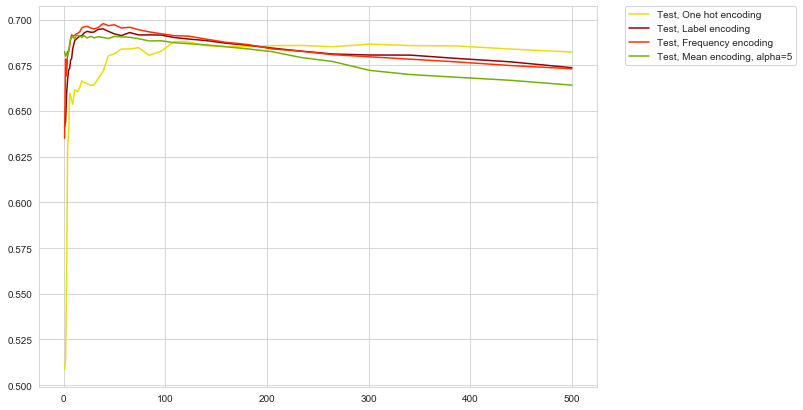

In [384]:
test_all_encodings(train_data,test_data,target_col,testing_params,test_one_hot=True,regression=False)

Takeaway from categorical encoding:
On test set performance: 
Green line (mean encoding with alpha = 5) gives fastest convergence to minimum RMSE.
All these 3 methods are outperformed by one hot encoding as we increase the number of iterations. 

In [14]:
# Dealing with numerical features
from sklearn.preprocessing import StandardScaler
normed_df = df.copy()

scaler = StandardScaler()

for col in feature_num_cols:
    scaled_col = scaler.fit_transform(normed_df[col].values.reshape((-1,1)))
    normed_df[col] = scaled_col